### 1. Read maps buildings, roads and project

In [34]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from longsgis import voronoiDiagram4plg
from sklearn.cluster import KMeans

# ---------------------------
# 1. Data Loading & Preparation
# ---------------------------

# Use current notebook's folder as the root
root_path = Path().resolve() / "maps"

# Define subfolders
buildings_path = root_path / "buildings" / "buildings.shp"
roads_path = root_path / "roads" / "roads.shp"
area_path = root_path / "area_project" / "Planungsgebiet_hyBit.shp"

# Read files and convert to consistent CRS (UTM Zone 32N for accurate measurements)
target_crs = "EPSG:32632"

gdf_buildings = gpd.read_file(buildings_path).to_crs(target_crs)
gdf_roads = gpd.read_file(roads_path).to_crs(target_crs)
gdf_area = gpd.read_file(area_path).to_crs(target_crs)

# Create a single geometry for your project area
area_poly = gdf_area.geometry.unary_union

# Filter buildings and roads by intersection with the area
gdf_buildings = gdf_buildings[gdf_buildings.geometry.intersects(area_poly)].copy()
gdf_roads = gdf_roads[gdf_roads.geometry.intersects(area_poly)].copy()

# Remove invalid geometries
gdf_buildings = gdf_buildings[gdf_buildings.is_valid]
gdf_roads = gdf_roads[gdf_roads.is_valid]
gdf_area = gdf_area[gdf_area.is_valid]

# Exclude irrelevant building types
exclude_types = {"farm", "garage", "garages", "roof", "shed", "yes"}
gdf_buildings = gdf_buildings[~gdf_buildings["building"].isin(exclude_types)]


/tmp/ipykernel_194389/514811155.py:28: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  area_poly = gdf_area.geometry.unary_union


### 2. Plot them, to see the maps you are using

/tmp/ipykernel_194389/2845935160.py:11: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


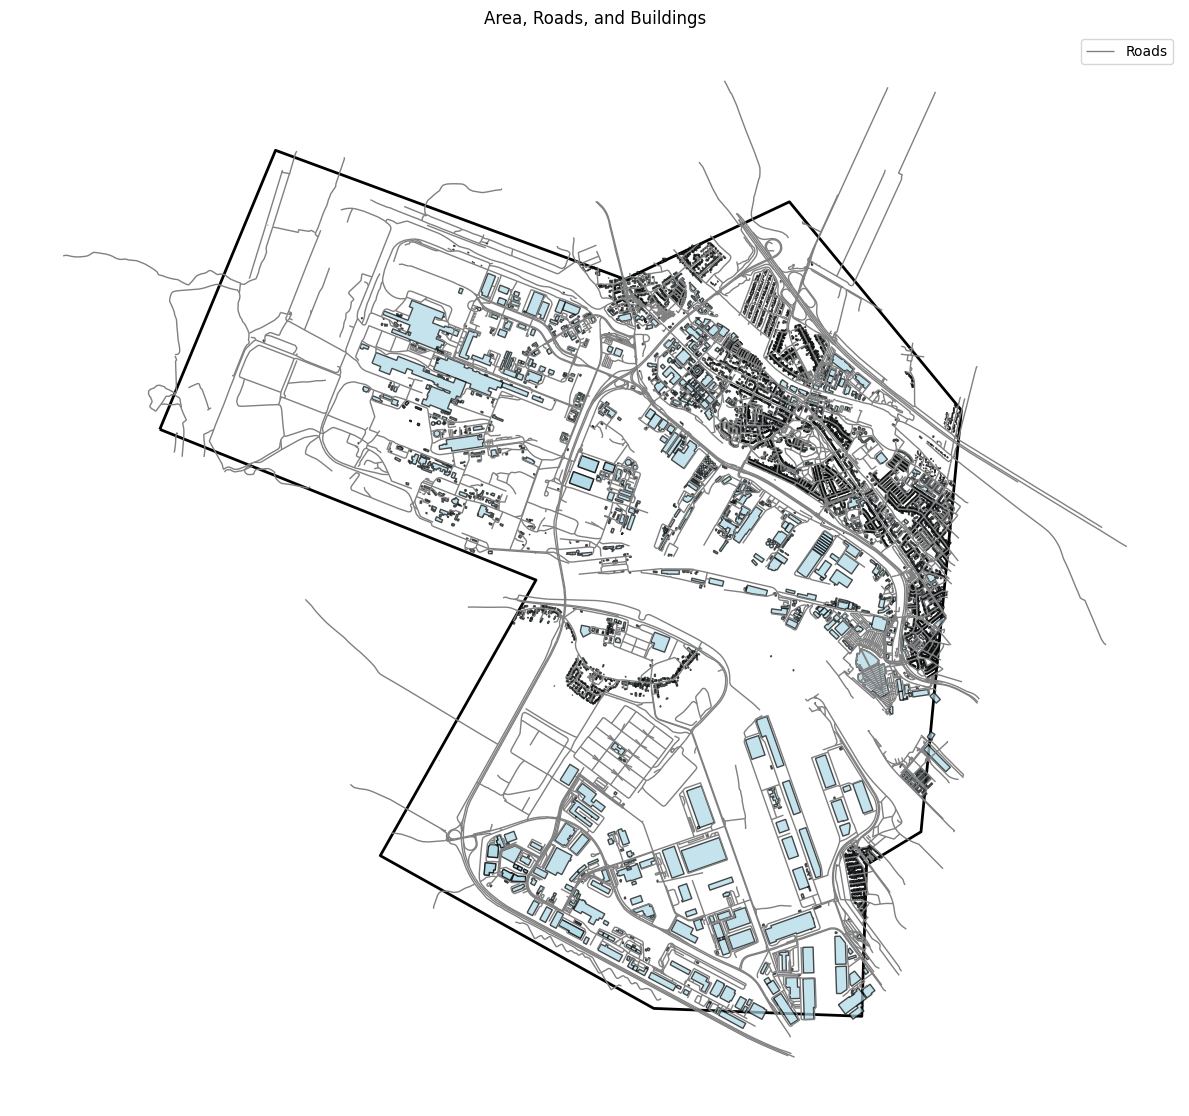

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 12))

# Plot each GeoDataFrame with custom style
gdf_area.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=2, label='Area')
gdf_roads.plot(ax=ax, color='gray', linewidth=1, label='Roads')
gdf_buildings.plot(ax=ax, color='lightblue', edgecolor='black', alpha=0.7, label='Buildings')

# Add legend and title
plt.legend()
plt.title("Area, Roads, and Buildings")
plt.axis('off')
plt.tight_layout()
plt.show()


### 3. Assign some maximum loads

This step may change, so you should actually aggregate the building load profiles and find the maximum power demand to define the S/E power.

In [39]:

# ---------------------------
# 2. Load Assignment
# ---------------------------

# Prepare masks
mask_res = gdf_buildings['building'] == 'residential'
mask_C = gdf_buildings['building'] == 'C'
mask_oth = ~(mask_res | mask_C)

# Helper to draw N samples from a normal, then clip to [low, high]
def truncated_normal(size, low, high):
    mean = (low + high) / 2
    sd = (high - low) / 4  # ~95% of data in [low,high]
    vals = np.random.normal(loc=mean, scale=sd, size=size)
    return np.clip(vals, low, high)

# Create the column, default zero
gdf_buildings['load[kVA]'] = 0.0

# Assign values per category
gdf_buildings.loc[mask_res, 'load[kVA]'] = truncated_normal(mask_res.sum(), 2.1, 11.4)
gdf_buildings.loc[mask_C, 'load[kVA]'] = truncated_normal(mask_C.sum(), 100, 40000)
gdf_buildings.loc[mask_oth, 'load[kVA]'] = truncated_normal(mask_oth.sum(), 10, 3000)

# Inspect
print(gdf_buildings[['building','load[kVA]']].groupby('building').describe())


            load[kVA]                                                        \
                count          mean          std          min           25%   
building                                                                      
A                58.0   1488.915770   784.458410    10.000000    820.826406   
C               991.0  20093.143786  9408.950817   100.000000  13388.977059   
D                 1.0    840.009939          NaN   840.009939    840.009939   
F                 8.0   1739.180152   652.163846   637.319742   1281.347240   
G               173.0   1520.283568   731.740988    10.000000    993.459734   
H                82.0   1554.263284   686.461254    10.000000    988.790037   
I                 1.0   1520.201455          NaN  1520.201455   1520.201455   
M                 5.0   1232.549552  1099.593488    10.000000    770.997432   
N                15.0   1697.137737   711.109427   802.657855   1072.212845   
O                15.0   1672.828180   886.635688    

### 4. Convert them to json files

In [25]:
from pathlib import Path
import geopandas as gpd

def export_to_geojson(gdf: gpd.GeoDataFrame, filename: str, foldername: str = "maps"):
    # Create output folder
    output_dir = Path().resolve() / foldername
    output_dir.mkdir(parents=True, exist_ok=True)

    # Define full path
    output_path = output_dir / filename

    # Save as GeoJSON
    gdf.to_file(output_path, driver="GeoJSON")
    print(f"Saved: {output_path}")

# Usage:
export_to_geojson(gdf_buildings, "gdf_buildings.geojson")
export_to_geojson(gdf_area, "gdf_area.geojson")


Saved: /home/zaba_al/projects/voroni/maps/gdf_buildings.geojson
Saved: /home/zaba_al/projects/voroni/maps/gdf_area.geojson


### 5. Find voronoi polygons identifying buildings and associated loads

/tmp/ipykernel_194389/3209665486.py:13: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  area_geom = gdf_area.unary_union
/tmp/ipykernel_194389/3209665486.py:23: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  multipoint = gpd.GeoSeries(centroids).unary_union


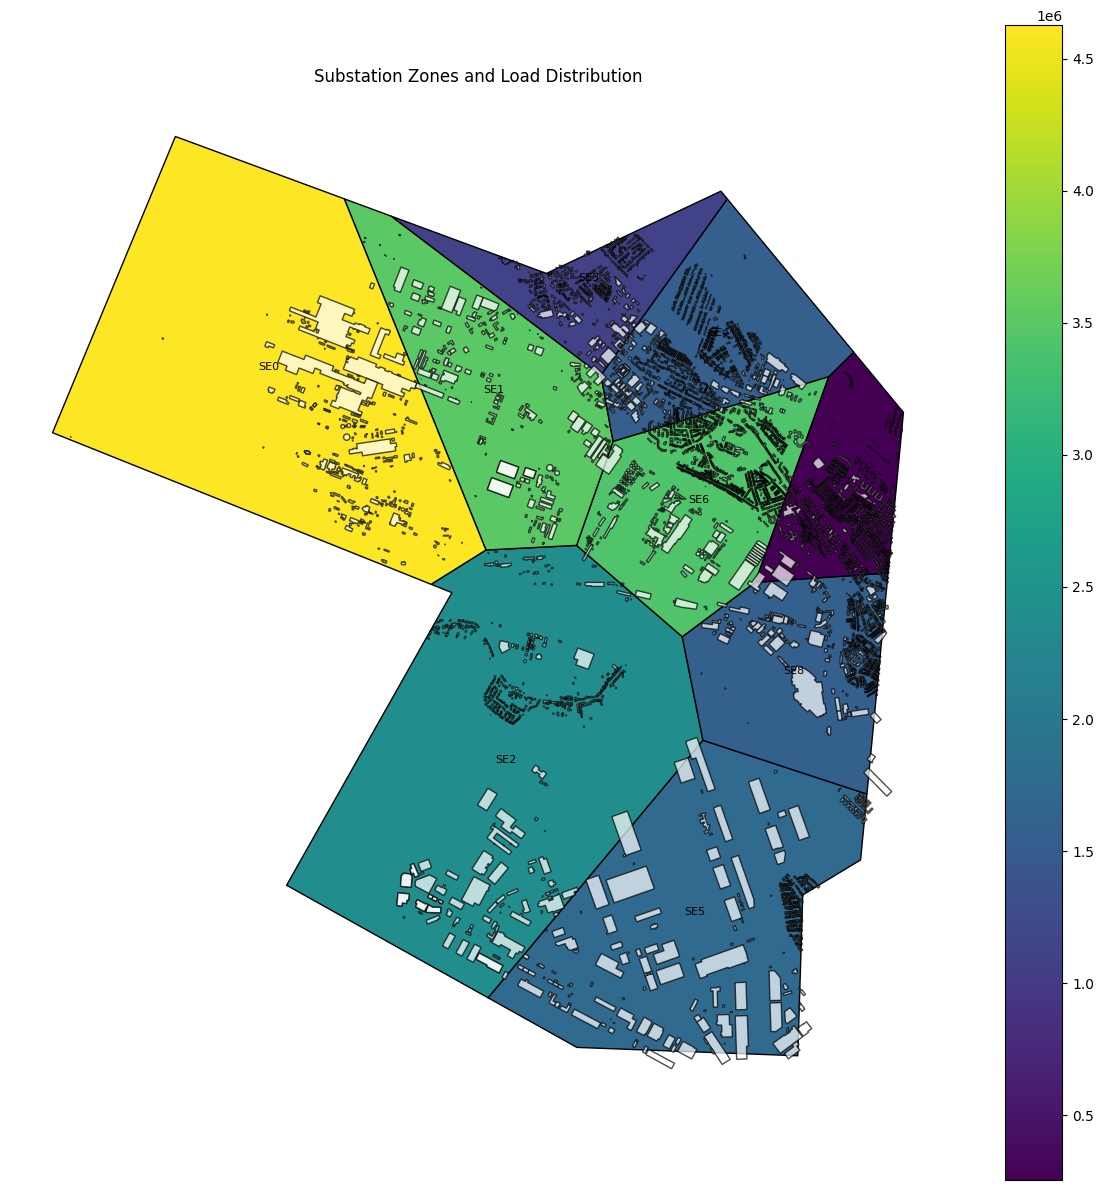

In [45]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.ops import voronoi_diagram
from sklearn.cluster import KMeans

# === Load your actual data ===
gdf_buildings = gpd.read_file(root_path / "gdf_buildings.geojson")
gdf_area = gpd.read_file(root_path /"gdf_area.geojson")

# === Parameters ===
target_zone_spacing_m = 2000
area_geom = gdf_area.unary_union
area_sqm = area_geom.area
n_substations = int(area_sqm // (target_zone_spacing_m**2))

# === Step 1: Cluster building centroids ===
coords = gdf_buildings.geometry.centroid.apply(lambda p: (p.x, p.y)).to_list()
kmeans = KMeans(n_clusters=n_substations, random_state=0).fit(coords)
centroids = [Point(xy) for xy in kmeans.cluster_centers_]

# === Step 2: Voronoi diagram from centroids ===
multipoint = gpd.GeoSeries(centroids).unary_union
voronoi = voronoi_diagram(multipoint, envelope=area_geom)

# === Step 3: Convert to GeoDataFrame and clip ===
gdf_voronoi = gpd.GeoDataFrame(geometry=list(voronoi.geoms), crs=gdf_area.crs)
gdf_voronoi = gpd.clip(gdf_voronoi, area_geom)
gdf_voronoi["SE_id"] = gdf_voronoi.index

# === Step 4: Assign buildings to substation polygons ===
gdf_buildings = gdf_buildings.copy()
gdf_buildings["centroid"] = gdf_buildings.geometry.centroid
gdf_buildings_centroids = gpd.GeoDataFrame(
    gdf_buildings.drop(columns="geometry"),
    geometry=gdf_buildings["centroid"],
    crs=gdf_buildings.crs
)

joined = gpd.sjoin(gdf_buildings_centroids, gdf_voronoi, how="left", predicate="within")

# === Step 5: Aggregate data by SE zone ===
aggregated = joined.groupby("SE_id").agg({
    "osm_id": list,
    "building": list,
    "load[kVA]": "sum"
}).reset_index()

# === Step 6: Merge results into Voronoi GeoDataFrame ===
gdf_voronoi = gdf_voronoi.merge(aggregated, on="SE_id", how="left")

gdf_voronoi

# === Step 7: Plot ===
fig, ax = plt.subplots(figsize=(12, 12))
gdf_voronoi.plot(ax=ax, column="load[kVA]", cmap="viridis", edgecolor="black", legend=True)
gdf_buildings.plot(ax=ax, markersize=10, color="white", edgecolor="black", alpha=0.7)

for idx, row in gdf_voronoi.iterrows():
    centroid = row.geometry.centroid
    ax.annotate(f"SE{row['SE_id']}", (centroid.x, centroid.y), ha="center", fontsize=8, color="black")

plt.title("Substation Zones and Load Distribution")
plt.axis("off")
plt.tight_layout()
plt.show()


### See information about the buildings on each polygon (S/E) and the attended loadThis step may change, so you should actually aggregate building load profiles and find the max. power demand to define S/E power.

In [51]:
import ace_tools_open as tools

tools.display_dataframe_to_user(name="Voronoi Zones", dataframe=gdf_voronoi)
tools.display_dataframe_to_user(name="Load Statistics", dataframe=gdf_voronoi['load[kVA]'].describe().to_frame())
print("Total Load [kVA]:", gdf_voronoi['load[kVA]'].sum())

Voronoi Zones


Load Statistics


Total Load [kVA]: 20204276.548919257
